In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=False)
%matplotlib inline

TRANSMITTED = 1
REFLECTED = 0
ABSORBED = 2

DOWN = 1
UP = -1

def exp_dist(x):
    return -np.log(1-x)

def draw_random_tau():
    xi = np.random.random()
    tau = exp_dist(xi)
    return tau

def change_direction(current_dir):
    if(current_dir == DOWN):
        return UP
    else:
        return DOWN

# Will return 1 if transmitted, 0 if reflected, 2 if absorbed, and -1 for issues
def track_photon(tau_bar, g_asym, absorb_wpi):
    depth = draw_random_tau()
    prob_forward = (1+g_asym)/2
    direction = DOWN
    #print("First tau is "+str(depth))
    while(depth>0 and depth<tau_bar):
        absorb_random = np.random.random()
        if(absorb_random > absorb_wpi):
            #print("Photon Absorbed!")
            return ABSORBED
        dir_random = np.random.random()
        if(dir_random > prob_forward):
            #print("Direction Changed")
            direction = change_direction(direction)
        next_tau = draw_random_tau()
        depth = depth + direction*next_tau
        #print("New depth: "+str(depth))
    if(depth>tau_bar):
        #print("Photon Transmitted!")
        return TRANSMITTED
    elif(depth<0):
        #print("Photon Reflected!")
        return REFLECTED
    else:
        return -1

In [3]:
def full_sim(num_photons, tau_bar, g_asym, absorb_wpi): 
    
    reflect_count = 0
    trans_count = 0
    absorb_count = 0
    
    #print("Starting sim for tau_bar = "+str(tau_bar)  +" and g="+str(g_asym) + " and curly pi = " + str(absorb_wpi))
    
    for i in range(num_photons):
        result = track_photon(tau_bar, g_asym, absorb_wpi)
        if(result == TRANSMITTED):
            trans_count = trans_count+1
        elif(result == REFLECTED):
            reflect_count = reflect_count+1
        elif(result == ABSORBED):
            absorb_count = absorb_count +1
        else:
            print("Error in photon tracking")
    return [reflect_count/num_photons, trans_count/num_photons, absorb_count/num_photons]

In [11]:
num_taus = 50
tb = np.linspace(1, 100, num_taus)
ref = np.zeros(num_taus)
tran = np.zeros(num_taus)
absorb = np.zeros(num_taus)

wpi = 1
g = 0.85
n_photons = 1000

for i in range(num_taus):
    results = full_sim(n_photons, tb[i], g, wpi)
    ref[i] = results[0]
    tran[i] = results[1]
    absorb[i] = results[2]

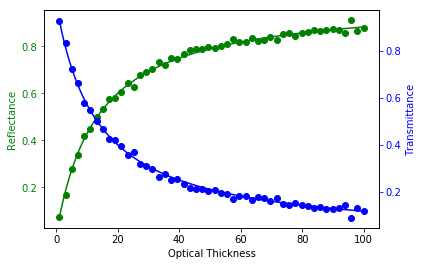

In [12]:
t_range = np.linspace(1,100, 1000)
fig, ax1 = plt.subplots()
ax1.plot(tb, ref, 'og', label="Reflected")
ax1.plot(t_range, t_range/(2/(1-g)+t_range), "-g")
ax1.set_ylabel('Reflectance', color='g')
ax1.tick_params('y', colors='g')

ax1.set_xlabel("Optical Thickness")

ax2 = ax1.twinx()
ax2.plot(tb, tran, 'ob', label="Transmitted")
ax2.plot(t_range, 1/((1-g)*t_range/2+1), "-b", label="Transmitted True")
ax2.set_ylabel('Transmittance', color='b')
ax2.tick_params('y', colors='b')